In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.callbacks import LearningRateScheduler

In [3]:
from tensorflow.keras.utils import to_categorical

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [5]:
train = pd.read_csv(r"C:\Users\range\Downloads\digit-recognizer\train.csv")
test = pd.read_csv(r"C:\Users\range\Downloads\digit-recognizer\test.csv")

In [6]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)
X_train = X_train / 255.0
X_test = test / 255.0
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
Y_train = to_categorical(Y_train, num_classes = 10)

In [7]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [8]:
from tensorflow.keras import layers, models

nets = 2   # reduced from 15
models_list = []

for _ in range(nets):
    m = models.Sequential([
        layers.Input(shape=(28,28,1)),

        # Block 1
        layers.Conv2D(16, 3, activation='relu'),
        layers.Conv2D(16, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        # Dense
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(10, activation='softmax')
    ])

    m.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    models_list.append(m)


In [9]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
history = [0] * nets
epochs = 20

for j in range(nets):
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(
        X_train, Y_train, test_size=0.1
    )

    history[j] = models_list[j].fit(
        datagen.flow(X_train2, Y_train2, batch_size=64),
        epochs=epochs,
        validation_data=(X_val2, Y_val2),
        callbacks=[annealer],
        verbose=1
    )

    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1,
        epochs,
        max(history[j].history['accuracy']),
        max(history[j].history['val_accuracy'])
    ))


Epoch 1/20


C:\Users\range\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


591/591 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - accuracy: 0.7640 - loss: 0.7108 - val_accuracy: 0.9683 - val_loss: 0.1035 - learning_rate: 0.0010
Epoch 2/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.9145 - loss: 0.2786 - val_accuracy: 0.9781 - val_loss: 0.0721 - learning_rate: 9.5000e-04
Epoch 3/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.9369 - loss: 0.2100 - val_accuracy: 0.9843 - val_loss: 0.0546 - learning_rate: 9.0250e-04
Epoch 4/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.9454 - loss: 0.1776 - val_accuracy: 0.9840 - val_loss: 0.0501 - learning_rate: 8.5737e-04
Epoch 5/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.9539 - loss: 0.1540 - val_accuracy: 0.9869 - val_loss: 0.0436 - learning_rate: 8.1451e-04
Epoch 6/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.9575 - loss: 0.1410 - val_accuracy: 0.9864 - val_loss: 0.0414 - learning_rate: 7.7378e-04
Epoch 7/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0

In [10]:
results = np.zeros((X_test.shape[0], 10))

for j in range(nets):
    results += models_list[j].predict(X_test, verbose=0)

results = np.argmax(results, axis=1)

results = pd.Series(results, name="Label")

submission = pd.concat(
    [pd.Series(range(1, 28001), name="ImageId"), results],
    axis=1
)

submission.to_csv("MNIST-CNN-ENSEMBLE.csv", index=False)


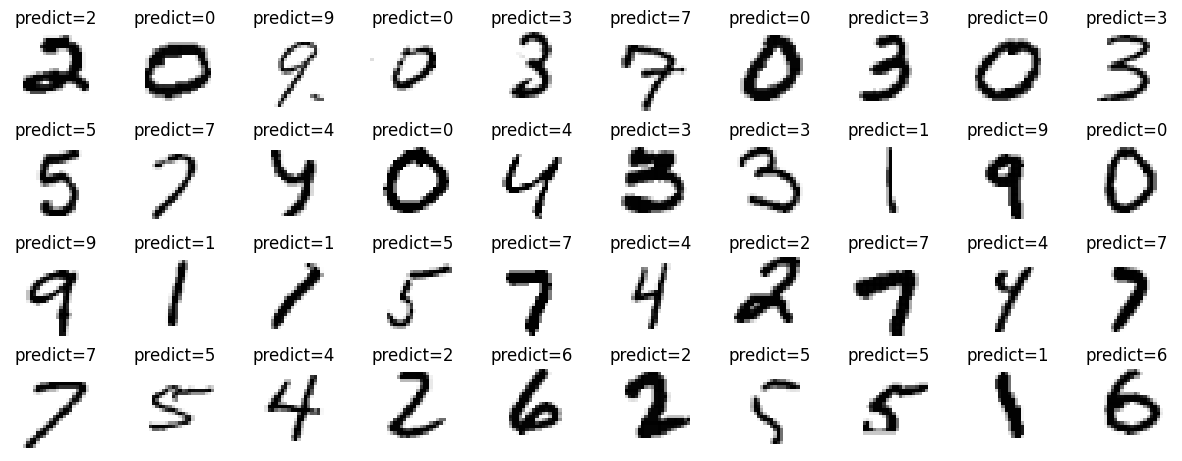

In [13]:
plt.figure(figsize=(15,6))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(X_test[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.title("predict=%d" % results[i],y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

In [12]:
import matplotlib.pyplot as plt